In [22]:
import datetime
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from gymnasium.wrappers import RecordVideo

# Only work with scipy 1.12.0
# https://discourse.pymc.io/t/importerror-cannot-import-name-gaussian-from-scipy-signal/14170/3
from scipy.signal import convolve, gaussian


In [23]:
def make_env(env_name, seed=13):
    np.random.seed(seed)
    # remove time limit wrapper from environment
    env = gym.make(env_name, render_mode="rgb_array").unwrapped
    return env

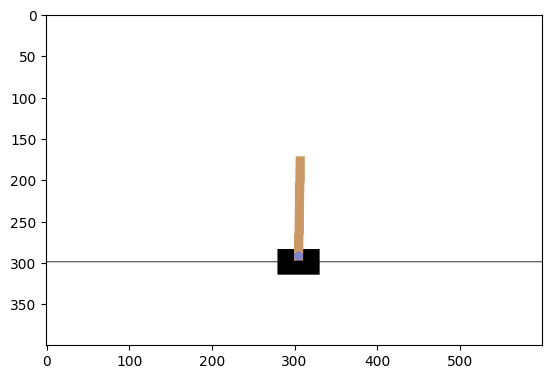

In [24]:
env_name = "CartPole-v1"

env = make_env(env_name)
env.reset()
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        state_dim = state_shape[0]
        # a simple NN with state_dim as input vector (inout is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module("layer1", nn.Linear(state_dim, 192))
        self.network.add_module("relu1", nn.ReLU())
        self.network.add_module("layer2", nn.Linear(192, 256))
        self.network.add_module("relu2", nn.ReLU())
        self.network.add_module("layer3", nn.Linear(256, 64))
        self.network.add_module("relu3", nn.ReLU())
        self.network.add_module("layer4", nn.Linear(64, n_actions))
        #
        self.parameters = self.network.parameters

    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [27]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [28]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = (
                qvalues.argmax(axis=-1)[0]
                if greedy
                else agent.sample_actions(qvalues)[0]
            )
            s, r, done, _, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [29]:
print(evaluate(env, agent, n_games=1))
env.close()

28.0


In [30]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []  # array to holde buffer
        self.next_id = 0

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(done_flags),
        )

In [31]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):
    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]
        next_s, r, done, _, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s, _ = env.reset()
        else:
            s = next_s

    return sum_rewards, s

In [32]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [33]:
def compute_td_loss(
    agent,
    target_network,
    states,
    actions,
    rewards,
    next_states,
    done_flags,
    gamma=0.99,
    device=device,
):
    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(
        done_flags.astype("float32"), device=device, dtype=torch.float
    )

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values, _ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values"
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1 - done_flags)

    # mean squared error loss to minimize
    loss = torch.mean(
        (predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2
    )

    return loss

In [34]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange


In [35]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [36]:
# setup env and agent and target networks
env_name = "CartPole-v1"
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [37]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [38]:
# setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**4

# init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [39]:
mean_rw_history = []
td_loss_history = []


In [40]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps - start_eps) * min(step, final_step) / final_step


def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, "valid")

buffer size = 10000, epsilon = 0.05000


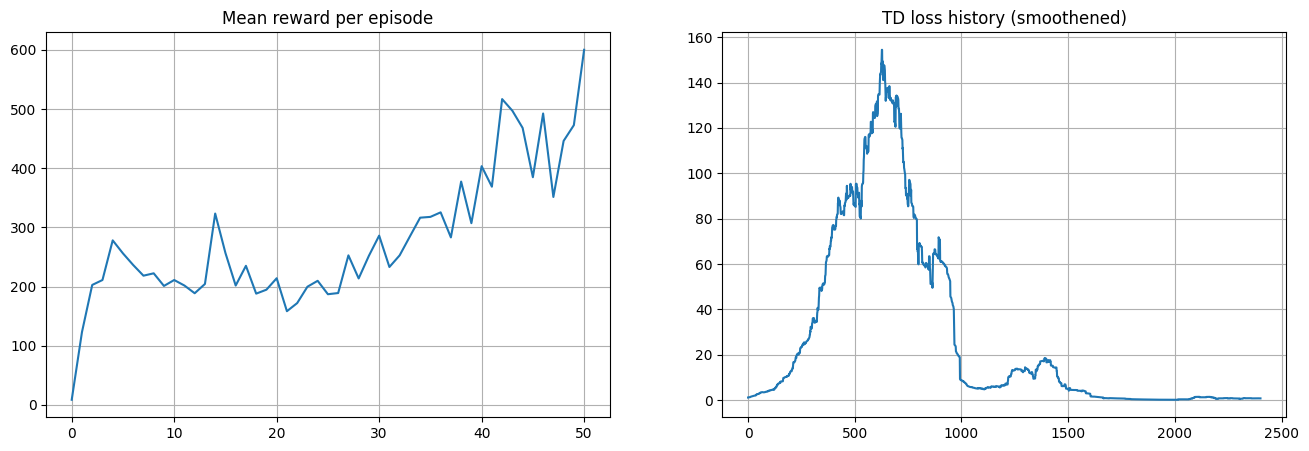

100%|██████████| 50001/50001 [02:24<00:00, 345.58it/s]


In [41]:
state, _ = env.reset()

for step in trange(total_steps + 1):
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(
        start_epsilon, end_epsilon, step, eps_decay_final_step
    )

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)

    # loss = <compute TD loss>
    loss = compute_td_loss(
        agent,
        target_network,
        states,
        actions,
        rewards,
        next_states,
        done_flags,
        gamma=0.99,
        device=device,
    )

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(
            evaluate(
                make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000
            )
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [43]:
env.close()
env = gym.make("CartPole-v1", render_mode="rgb_array")
timestamp = int(datetime.datetime.now().timestamp())
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)
state, _ = env.reset()
reward = 0
while True:
    qvalues = agent.get_qvalues([state])
    action = qvalues.argmax(axis=-1)[0]
    state, r, done, _, _ = env.step(action)
    reward += r
    if done:
        print("Got reward: {}".format(reward))
        break


env.close()

c:\Users\admin\Coding\research\rl-training-2025-codes\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\admin\Coding\research\rl-training-2025-codes\src\T05_deep_q\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Got reward: 265.0
